In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gluonts.dataset.repository.datasets import get_dataset

import torch
from pytorch_forecasting import NBeats, TimeSeriesDataSet

import lightning.pytorch as ptl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner


from matplotlib import pyplot as plt

In [2]:
dataset = get_dataset("nn5_daily_without_missing", regenerate=False)

N_LAGS = 7
HORIZON = 7

In [3]:
class LogTransformation:
    @staticmethod
    def transform(x):
        xt = np.sign(x) * np.log(np.abs(x) + 1)

        return xt

    @staticmethod
    def inverse_transform(xt):
        x = np.sign(xt) * (np.exp(np.abs(xt)) - 1)

        return x

In [4]:
class LocalScaler:
    def __init__(self):
        self.scalers = {}

    def fit(self, df: pd.DataFrame):
        df = df.copy()
        df_g = df.groupby("group_id")
        for g, df_ in df_g:
            scl = StandardScaler()
            scl.fit(df_[["value"]])

            self.scalers[g] = scl

    def transform(self, df: pd.DataFrame):
        df = df.copy()
        df["value"] = LogTransformation.transform(df["value"])

        df_g = df.groupby("group_id")
        transf_df_l = []
        for g, df_ in df_g:
            df_[["value"]] = self.scalers[g].transform(df_[["value"]])

            transf_df_l.append(df_)

        transf_df = pd.concat(transf_df_l)
        transf_df = transf_df.sort_index()

        return transf_df

In [5]:
class GlobalDataModule(ptl.LightningDataModule):
    def __init__(
        self, data, n_lags: int, horizon: int, test_size: float, batch_size: int
    ):
        super().__init__()

        self.data = data
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon

        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None

        self.target_scaler = LocalScaler()

    def setup(self, stage=None):
        data_list = list(self.data.train)

        data_list = [
            pd.Series(
                ts["target"],
                index=pd.date_range(
                    start=ts["start"].to_timestamp(),
                    freq=ts["start"].freq,
                    periods=len(ts["target"]),
                ),
            )
            for ts in data_list
        ]

        tseries_df = pd.concat(data_list, axis=1)
        tseries_df["time_index"] = np.arange(tseries_df.shape[0])

        ts_df = tseries_df.melt("time_index")
        ts_df = ts_df.rename(columns={"variable": "group_id"})

        unique_times = ts_df["time_index"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(
            unique_times, test_size=self.test_size, shuffle=False
        )

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.1, shuffle=False)

        training_df = ts_df.loc[ts_df["time_index"].isin(tr_ind), :]
        validation_df = ts_df.loc[ts_df["time_index"].isin(vl_ind), :]
        test_df = ts_df.loc[ts_df["time_index"].isin(ts_ind), :]

        self.target_scaler.fit(training_df)

        training_df = self.target_scaler.transform(training_df)
        validation_df = self.target_scaler.transform(validation_df)
        test_df = self.target_scaler.transform(test_df)

        self.training = TimeSeriesDataSet(
            data=training_df,
            time_idx="time_index",
            target="value",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=["value"],
            target_normalizer=None,
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, ts_df, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)

In [6]:
datamodule = GlobalDataModule(
    data=dataset, n_lags=N_LAGS, horizon=HORIZON, batch_size=256, test_size=0.2
)

datamodule.setup()

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


In [7]:
model = NBeats.from_dataset(
    dataset=datamodule.training,
    stack_types=["trend", "seasonality"],
    num_blocks=[3, 3],  # The number of blocks per stack.
    num_block_layers=[4, 4],  # Number of fully connected layers
    widths=[256, 2048],
    sharing=[True],
    backcast_loss_ratio=1.0,
)

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [8]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

trainer = ptl.Trainer(
    max_epochs=2,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(
    model,
    train_dataloaders=datamodule.train_dataloader(),
    val_dataloaders=datamodule.val_dataloader(),
)

You are using a CUDA device ('NVIDIA GeForce RTX 5060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss            | MASE       | 0      | train | 0    
1 | logging_metrics | ModuleList | 0      | train | 0    
2 | net_blocks      | ModuleList | 38.5 M | train | 0    
---------------------------------------------------------------
38.5 M    Trainable params
0         Non-trainable params
38.5 M    Total params
153.840   Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [11]:
trainer.checkpoint_callback.best_model_path

'/home/volody/code/study-py/ts-pytorch/Chapter_6/lightning_logs/version_1/checkpoints/epoch=1-step=446.ckpt'

In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path, weights_only=False)

actuals = torch.cat(
    [y[0] for x, y in iter(datamodule.test.to_dataloader(batch_size=1, shuffle=False))]
)
predictions = best_model.predict(
    datamodule.test.to_dataloader(batch_size=1, shuffle=False)
)
(actuals - predictions.cpu()).abs().mean()

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-pac

tensor(0.3162)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


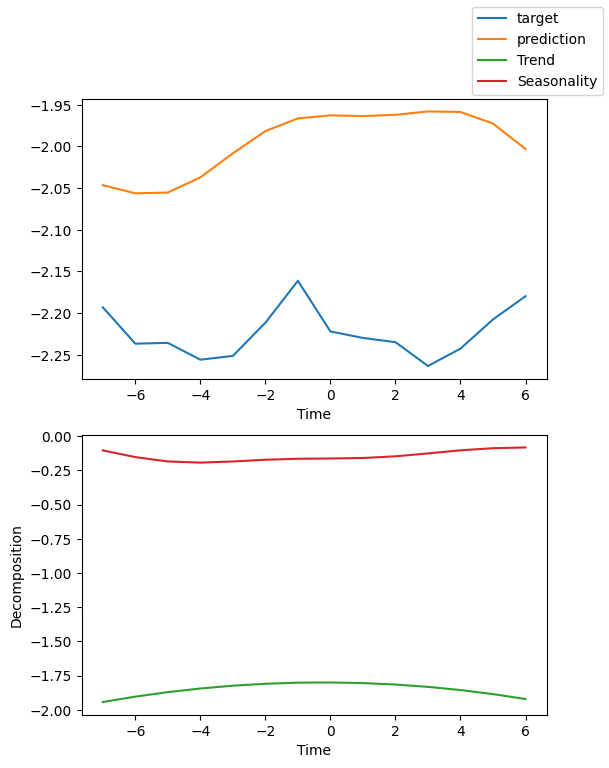

In [14]:
raw_predictions = best_model.predict(
    datamodule.val_dataloader(), mode="raw", return_x=True
)

best_model.plot_interpretation(x=raw_predictions[1], output=raw_predictions[0], idx=0)
plt.show()

In [16]:
forecasts = best_model.predict(datamodule.predict_dataloader())
forecasts

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


tensor([[-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.958

In [17]:
forecasts.shape

torch.Size([111, 7])

In [18]:
forecasts

tensor([[-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.9587, -1.9727, -2.0031],
        [-1.9628, -1.9637, -1.9622, -1.9581, -1.958

In [29]:
trainer = ptl.Trainer(accelerator="auto", gradient_clip_val=0.01)
tuner = Tuner(trainer)

model = NBeats.from_dataset(
    datamodule.training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=0.1,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [30]:
lr_optim = tuner.lr_find(
    model,
    train_dataloaders=datamodule.train_dataloader(),
    val_dataloaders=datamodule.val_dataloader(),
    min_lr=1e-5,
    # weights_only=False
)

lr_optim.suggestion(weights_only=False)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`weights_only` was not set, defaulting to `False`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Restoring states from the checkpoint path at /home/volody/code/study-py/ts-pytorch/Chapter_6/.lr_find_b15b27d5-bef3-47e2-901e-d10598625a6d.ckpt


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pytorch_forecasting.data.encoders.TorchNormalizer was not an allowed global by default. Please use `torch.serialization.add_safe_globals([pytorch_forecasting.data.encoders.TorchNormalizer])` or the `torch.serialization.safe_globals([pytorch_forecasting.data.encoders.TorchNormalizer])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:

fig = lr_optim.plot(show=True, suggest=True)
fig.show()